# **0. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
print("Hello, World!")

Mon Nov  3 12:11:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.09              Driver Version: 580.82.09      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              9W /   60W |      14MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **1. Connexion à la plateforme Wandb** ##

Weights and Biases (W&B) est une plateforme qui permet de suivre, visualiser et partager les résultats d'expériences en temps réel. Cela permet de faciliter le tracking des expériences. Veuillez Créer vous un compte en allant sur le lien [https://wandb.ai/site](https://wandb.ai/site)

In [2]:
import wandb
wandb.login(key="0909e1fa38ddadeac2039f7909334419ad911c08")

/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

True

# **2.1. Importation des libraries** ##



In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import cv2
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
import wandb
# !pip install pytorch_lightning
from torchinfo import summary
from torchmetrics import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger , CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
torch.set_float32_matmul_precision('medium')

/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


# **3.1. Téléchargement du jeu de données d'entraînement** ##


In [4]:
# !rm -rf sample_data
# !wget https://nextcloud.ig.umons.ac.be/s/pB94TdAMJrr7JtQ/download/FIRE_DATABASE_1.zip
# !mkdir -p FIRE/train
# !unzip small.zip -d FIRE/train
# !rm small.zip

In [5]:
# DB1 : https://nextcloud.ig.umons.ac.be/s/nASDCFgsApgz8iB/download/FIRE_DATABASE_1.zip
# DB2 : https://nextcloud.ig.umons.ac.be/s/pB94TdAMJrr7JtQ/download/FIRE_DATABASE_2.zip
# DB3 : https://nextcloud.ig.umons.ac.be/s/GALdsKZfqDf9TyD/download/FIRE_DATABASE_3.zip

# **3.2. Téléchargement du jeu de données de test** ##

In [6]:
# !wget https://nextcloud.ig.umons.ac.be/s/GTf7wcpCFraPzxB/download/test.zip
# !unzip test.zip -d FIRE/test
# !rm test.zip

#**4. Paramètres d'entrainement "Hyper-paramètres"**

In [7]:
Train_data_path = "small" #@param ["small","DB1","DB2","DB3"]
Train_data_path = os.path.join('FIRE/train', Train_data_path)
Test_data_path = "test" #@param ["test","test_defi1"]
Test_data_path = os.path.join('FIRE/test', Test_data_path)
Batch_size=16 #@param [8,16,32,64,128,256] {type:"raw"}
Epochs=50 #@param [1,5, 10,20,50,100,200] {type:"raw"}
Learning_rate = 0.01 #@param [0.1, 0.01,0.02,0.05,0.001,0.002,0.005] {type:"raw"}
Train_split = 0.8 #@param [0.7,0.8,0.9] {type:"raw"}
Img_size = 224 #@param [224,299] {type:"raw"}
Accelerator= "auto" #@param ["cpu","gpu","auto"]
num_classes = 3
LOG_DIR="logs/"

#**5.1.Télécharger et afficher l'architecture du modèle préentrainé VGG16 (A COMPLETER)**

In [8]:
vggModel = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

print(vggModel)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **5.2. Définir modèle, param Forward/Backward & Transfer Leraning (A COMPLETER)** ##

In [9]:
class FireDetectionModel(pl.LightningModule):
    def __init__(self, num_classes=num_classes, learning_rate=Learning_rate):
        super().__init__()
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT) #prend en paramètre VGG
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes) #remplace derrnière couche pour notre classifcation

        # self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT) #ViT
        # in_features = self.model.heads.head.in_features
        # self.model.heads.head = nn.Linear(in_features, num_classes)

        # self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        # self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)


        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)

        self.log_dict({'train_loss':loss,"train_acc":acc}, on_step=True,prog_bar=True,logger=True, on_epoch=True)
        return {'loss': loss, 'train_acc': acc}

    def on_train_epoch_end(self):
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        val_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        val_acc = self.val_accuracy(predicted, labels)
        self.log_dict({'val_loss':val_loss,"val_acc":val_acc},prog_bar=True, on_step=False, on_epoch=True)
        return {'val_loss': val_loss, 'val_acc': val_acc}


    def on_validation_epoch_end(self):        
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        test_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        test_acc = self.test_accuracy(predicted, labels)
        self.log_dict({'test_loss':test_loss,"test_acc":test_acc},prog_bar=True, on_step=False, on_epoch=True)
        return {'test_loss': test_loss, 'test_acc': test_acc}

    def on_test_end(self):
        self.test_accuracy.reset()

    def configure_optimizers(self):
        return optim.Adam(self.parameters())



# **6. Afficher quelques images avec la fonction "display_class_images"(A COMPLETER)** ##

In [10]:
def display_class_images(class_path):
  import glob
  import matplotlib.image as mpimg
  images = []
  for img_path in glob.glob(class_path):
      images.append(mpimg.imread(img_path))
  plt.figure(figsize=(14,12))
  columns = 4
  for i, img in enumerate(images):
      if (i<=4):
        img=cv2.resize(img, (256,256))
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)

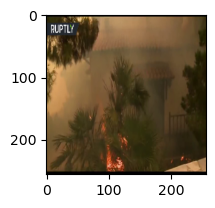

In [11]:
display_class_images('./FIRE/train/small/fire/00.png')

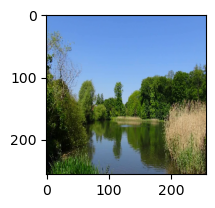

In [12]:
display_class_images('./FIRE/train/small/no_fire/0.png')

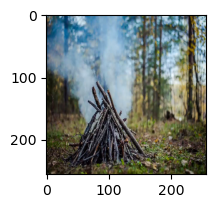

In [13]:
display_class_images('./FIRE/train/small/start_fire/0.png')

# **7. Création des jeux de données d'entraînement, validation et test "Data Loaders"** #

In [14]:
def create_data_loaders(dataset_path, testset_path, batch_size, train_split, img_size):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(train_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    test_dataset = datasets.ImageFolder(testset_path, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# **8. Définir les hyper-paramètres, EarlyStopping, Checkpoints et paramètres WandDB"** #

In [15]:
class TorchScriptExportCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        # Only save if this is the best model
        if trainer.checkpoint_callback.best_model_path:
            export_path = os.path.join("checkpoints", "best_vgg_DB2_model_jit.pth")
            scripted = pl_module.to_torchscript()
            torch.jit.save(scripted, export_path)

# Initialize wandb
wandb.init(project="fire-detection", config={
    "learning_rate": Learning_rate,
    "epochs": Epochs,
    "batch_size": Batch_size,
    "model": "resnet152",
})

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    Train_data_path, Test_data_path, Batch_size, Train_split, Img_size
)

# Initialize model
model = FireDetectionModel(num_classes=3, learning_rate=Learning_rate)

# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min'
)


# Initialize WandbLogger
wandb_logger = WandbLogger(project="fire-detection")

# Initialize WandbLogger
csv_logger = CSVLogger(LOG_DIR, name="cnn", version='')

torchscript_callback = TorchScriptExportCallback()

# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=Epochs,
    accelerator=Accelerator,
    log_every_n_steps=1,
    devices=1,
    logger=[wandb_logger, csv_logger],
    callbacks=[checkpoint_callback, early_stop_callback, torchscript_callback],
)

/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# **9. Lancer l'entrainement (A COMPLETER)** #

In [16]:
# Train the model
trainer.fit(model, train_loader, val_loader)

/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/cnn/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /run/media/cyril/Windows/Users/cyril/Desktop/jjj/info/Ma2/tp/intro/projet/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
scripted = model.to_torchscript()  # or torch.jit.script(model)
torch.jit.save(scripted, "vit_model_jit.pth")

# **10. Evaluer le modèle (A COMPLETER)** ##

In [17]:
# Test the model
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cyril/anaconda3/envs/pythoLightningGpu/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.76106196641922
        test_loss           0.7202987670898438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7202987670898438, 'test_acc': 0.76106196641922}]

# **11. Afficher les courbes d'entrainement avec la fonction "plot_metrics"** ##

In [ ]:
def plot_metrics(log_folder):
  import pandas as pd
  import matplotlib.pyplot as plt

  # Load the CSV file generated by CSVLogger
  df = pd.read_csv(f'{LOG_DIR}/{log_folder}/metrics.csv')
  train_df = df[df['train_loss_epoch'].notna()]
  val_df = df[df['val_loss'].notna()]

  # Plot training loss
  plt.plot(train_df['epoch'], train_df['train_loss_epoch'], label='Train Loss')
  plt.plot(val_df['epoch'], val_df['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot training accuracy
  plt.plot(train_df['epoch'], train_df['train_acc_epoch'], label='Train Acc')
  plt.plot(val_df['epoch'], val_df['val_acc'], label='Val Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
# ???????????????????????????????????????????????????????????????????????????????????

# **12. Tester le modèle avec une image de test de votre choix (A COMPLETER)"**

In [ ]:
image_path = # ???????????????????????????????????????????????????????????????????????????????????

classes = ["fire", "no fire", "start fire"]

# Load and preprocess the image
img = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((Img_size, Img_size)),
    transforms.ToTensor(),
])
x = transform(img).unsqueeze(0).to("cuda")  # Add batch dimension

# Predict
model.eval()
with torch.no_grad():
    pred = model(x)
    probabilities = torch.nn.functional.softmax(pred[0], dim=0)

# Display results
plt.figure(figsize=(10, 10))
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for pos, prob in enumerate(probabilities):
    class_name = classes[pos]
    print(f"Class Name: {class_name} --- Class Probability: {prob.item()*100:.2f}%")

    if pos == torch.argmax(probabilities).item():
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) // 2
        textY = (img.shape[0] + textsize[1]) // 2
        cv2.putText(img, class_name, (textX-10, textY), font, 2, (255,0,0), 6, cv2.LINE_AA)

plt.imshow(img)
plt.axis('off')
plt.show()

# **13. QUESTION : APRES avoir complété et testé le code plus haut, analyser les résultats et proposer le meilleur modèle, données et hyper-paramètres pouvant répondre aux éxigences du défi 1 (voir l'énoncé)"**

In [ ]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################


# Verification database

In [12]:
import os
import cv2

def get_image_paths(dir_path, extensions=('jpg','png','jpeg','bmp')):
    paths = []
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(tuple(extensions)):
            paths.append(os.path.join(dir_path, fname))
    return paths

def compute_hash(img, method='phash'):
    if method == 'phash':
        hasher = cv2.img_hash.PHash_create()
    elif method == 'average':
        hasher = cv2.img_hash.AverageHash_create()
    # add other methods if you like
    else:
        raise ValueError(f"Unknown hash method {method}")
    h = hasher.compute(img)
    return h

def hamming_dist(hash1, hash2):
    # OpenCV hash values may come as numpy arrays of uchar; you can binary-compare them
    # For simplicity we use cv2's compare method if available
    # But you could also convert to bits and count differences
    return int(np.bitwise_xor(hash1, hash2).sum())  # simplistic; depends on hash format

def find_unique_images(dir_path, method='phash', threshold=0):
    """
    threshold = 0 → only exact same hashes are duplicates
    threshold > 0 → allow near-duplicates within a threshold
    """
    paths = get_image_paths(dir_path)
    hash_map = {}  # mapping `filename` → `hash`
    unique = []
    duplicates = []

    for p in paths:
        img = cv2.imread(p)
        if img is None:
            print(f"Warning: Could not read {p}")
            continue

        h = compute_hash(img, method=method)
        # Check against existing hashes
        found_dup = False
        for existing_path, existing_hash in hash_map.items():
            # compare
            # best is to use OpenCV's compare method:
            # e.g. hasher.compare(existing_hash, h)
            # but depends on API
            # fallback: compute manual hamming distance
            dist = cv2.img_hash.PHash_create().compare(existing_hash, h)
            if dist <= threshold:
                duplicates.append( (p, existing_path, dist) )
                found_dup = True
                break
        if not found_dup:
            unique.append(p)
            hash_map[p] = h

    return unique, duplicates


unique, duplicates = find_unique_images('./create top database/start_fire/', method='phash', threshold=0)
print("Unique images:", len(unique))
print("Duplicates:", len(duplicates))

# unique, duplicates = find_unique_images('./test/fire/', method='phash', threshold=0)
# print("Unique images:", len(unique))
# print("Duplicates:", len(duplicates))

# unique, duplicates = find_unique_images('./test/start_fire/', method='phash', threshold=0)
# print("Unique images:", len(unique))
# print("Duplicates:", len(duplicates))


Unique images: 182
Duplicates: 486


### Résultat
Pour database 1 :
duplication de 186 élement dans fire, le reste aucun duplication

Pour database 2 :
30 image de pas de feu unique, 30 image de feu unique et 14 image de début de feu unique, le reste duplication

Pour database 3 :
même que database 2

database 2 = database 3

pour small :
aucune duplication + équilibré

pour test :
tout unique mais pas équilibré


En rassemblant start fire, remarque que seulement 182 élément unique. Comme c'est la classe la moins présente, pas interêt à utiliser autre chose que small comme déjà 172 dedans et donc pour équilibrage base de données mieux de ne pas touché
